In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/HEMOTOVISION

/content/drive/MyDrive/HEMOTOVISION


In [4]:
import os

data_dir = '/content/drive/MyDrive/HEMOTOVISION/DATASET/Dataset/dataset2-master/dataset2-master/images/TRAIN'
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
filepaths = []

for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue  # Skip missing folders
    for file in os.listdir(class_dir):
        if file.endswith('.jpeg') or file.endswith('.png'):
            filepaths.append(os.path.join(class_dir, file))


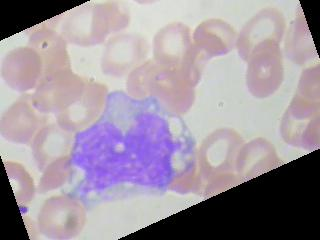

In [5]:
import random
from IPython.display import Image, display
train_dir='/content/drive/MyDrive/HEMOTOVISION/DATASET/Dataset/dataset2-master/dataset2-master/images/TRAIN'
class_dir = os.path.join(train_dir, random.choice(os.listdir(train_dir)))
image_path = os.path.join(class_dir, random.choice(os.listdir(class_dir)))
display(Image(filename=image_path))


Displaying a few random images from the dataset:


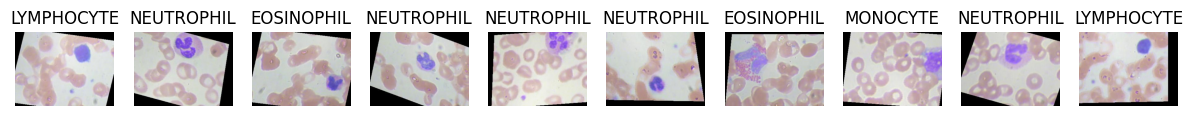

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2

# This function is from the document, adjusted to work with image paths
def show_blood_cell_images(image_generator):
    test_dict = image_generator.class_indices
    classes = list(test_dict.keys())

    # Get a batch of images and labels from the generator
    images, labels = next(image_generator)

    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 25) # Display up to 25 images

    for i in range(r):
        plt.subplot(5, 5, i + 1)
        # Denormalize image for display (assuming images are preprocessed to [-1, 1] by MobileNetV2 preprocess_input)
        image = (images[i] + 1) / 2
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="green", fontsize=16)
        plt.axis('off')
    plt.show()

# Displaying a few random images directly from the data_dir for initial visualization
print("Displaying a few random images from the dataset:")
num_images_to_display = 10
random_image_paths = random.sample(filepaths, num_images_to_display)

plt.figure(figsize=(15, 5))
for i, img_path in enumerate(random_image_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for matplotlib
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    # Extract label from the path for display
    label = os.path.basename(os.path.dirname(img_path))
    plt.title(label)
    plt.axis('off')
plt.show()

In [7]:
# Split data into training, testing, and validation sets
# First, split into train_images and test_images (70% train, 30% test)
from sklearn.model_selection import train_test_split

bloodCell_df = pd.DataFrame(filepaths, columns=['filepaths'])
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)

# Then, split train_images further into train_set and val_set (e.g., 80% of train_images for training, 20% for validation)
train_set, val_set = train_test_split(train_images, test_size=0.2, random_state=42)

print("Shape of train_set:", train_set.shape)
print("Shape of test_images:", test_images.shape)
print("Shape of val_set:", val_set.shape)
print("Shape of train_images (initial split):", train_images.shape)

Shape of train_set: (5585, 1)
Shape of test_images: (2993, 1)
Shape of val_set: (1397, 1)
Shape of train_images (initial split): (6982, 1)


In [8]:
print(train_set.columns)


Index(['filepaths'], dtype='object')


In [9]:
bloodCell_df = pd.DataFrame({
    'filepaths': filepaths,
    'label': label   # singular 'label'
})


In [10]:
# Step 1: Imports
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 2: Load image paths and labels from folders
data_dir = '/content/drive/MyDrive/HEMOTOVISION/DATASET/Dataset/dataset2-master/dataset2-master/images/TRAIN'
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

filepaths = []
labels = []

for label in class_labels:
    class_path = os.path.join(data_dir, label)
    if not os.path.exists(class_path):
        print(f"Missing: {class_path}")
        continue
    for file in os.listdir(class_path):
        if file.endswith(('.png', '.jpg', '.jpeg')):
            filepaths.append(os.path.join(class_path, file))
            labels.append(label)

# Step 3: Create DataFrame with correct column names
bloodCell_df = pd.DataFrame({
    'filepaths': filepaths,
    'label': labels   # ✅ singular "label"
})

# Optional: Check if everything loaded correctly
print(bloodCell_df.head())
print(bloodCell_df['label'].value_counts())

# Step 4: Train/Test/Validation Split
train_images, test_images = train_test_split(
    bloodCell_df, test_size=0.3, random_state=42, stratify=bloodCell_df['label'])

train_set, val_set = train_test_split(
    train_images, test_size=0.2, random_state=42, stratify=train_images['label'])

# Step 5: Image Preprocessing
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Step 6: Data Generators
train_gen = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="label",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

val_gen = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="label",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)

test_gen = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="label",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)

# Step 7 (Optional): Print class mapping
print("Class indices:", train_gen.class_indices)


                                           filepaths       label
0  /content/drive/MyDrive/HEMOTOVISION/DATASET/Da...  EOSINOPHIL
1  /content/drive/MyDrive/HEMOTOVISION/DATASET/Da...  EOSINOPHIL
2  /content/drive/MyDrive/HEMOTOVISION/DATASET/Da...  EOSINOPHIL
3  /content/drive/MyDrive/HEMOTOVISION/DATASET/Da...  EOSINOPHIL
4  /content/drive/MyDrive/HEMOTOVISION/DATASET/Da...  EOSINOPHIL
label
EOSINOPHIL    2515
NEUTROPHIL    2499
LYMPHOCYTE    2483
MONOCYTE      2478
Name: count, dtype: int64
Found 5585 validated image filenames belonging to 4 classes.
Found 1397 validated image filenames belonging to 4 classes.
Found 2993 validated image filenames belonging to 4 classes.
Class indices: {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


In [11]:
from tensorflow import keras
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(18432, activation='relu'), # Change this to match the Flatten output
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
model.summary() # Run this and verify the output shape of Flatten layer

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 23, 23, 512)    │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 23, 23, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18432)          │   235,948,03

 Total params: 260,993,156 (995.61 MB)

 Trainable params: 260,987,780 (995.59 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Step 1: Load the MobileNetV2 base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Step 2: Freeze the base model (optional: fine-tune later)
base_model.trainable = False

# Step 3: Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # 4 classes: eosinophil, lymphocyte, etc.

# Step 4: Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Step 5: Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 6: Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    verbose=1
)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 1183s 2s/step - accuracy: 0.3430 - loss: 1.5020 - val_accuracy: 0.5784 - val_loss: 1.0366
Epoch 2/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 350s 500ms/step - accuracy: 0.5151 - loss: 1.1163 - val_accuracy: 0.6535 - val_loss: 0.8777
Epoch 3/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 376s 492ms/step - accuracy: 0.5711 - loss: 0.9953 - val_accuracy: 0.6958 - val_loss: 0.7877
Epoch 4/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 393s 509ms/step - accuracy: 0.6176 - loss: 0.9178 - val_accuracy: 0.6922 - val_loss: 0.7621
Epoch 5/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 384s 511ms/step - accuracy: 0.6487 - loss: 0.8350 - val_accuracy: 0.7423 - val_loss: 0.6779


375/375 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step
Classification Report:
              precision    recall  f1-score   support

  eosinophil       0.70      0.66      0.68       755
  lymphocyte       0.83      0.90      0.86       745
    monocyte       0.75      0.90      0.81       743
  neutrophil       0.76      0.59      0.66       750

    accuracy                           0.76      2993
   macro avg       0.76      0.76      0.75      2993
weighted avg       0.76      0.76      0.75      2993

Accuracy of the Model: 76.0%


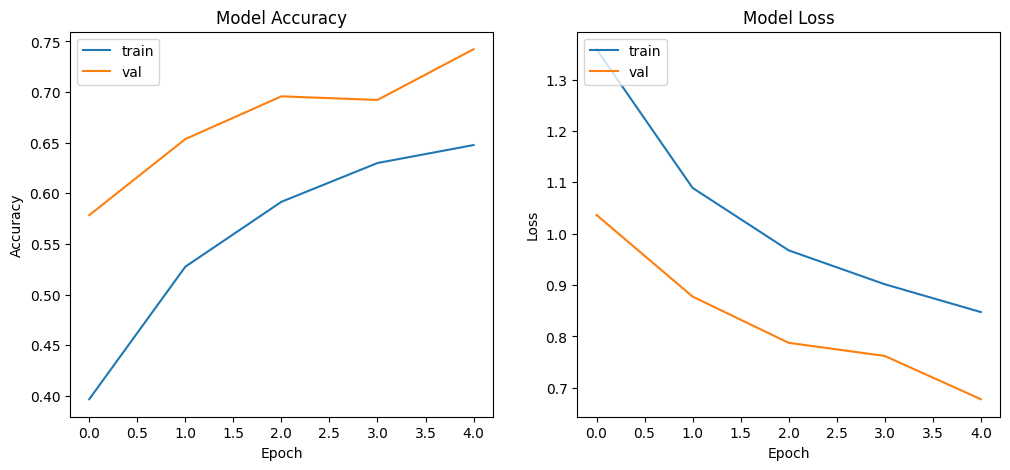

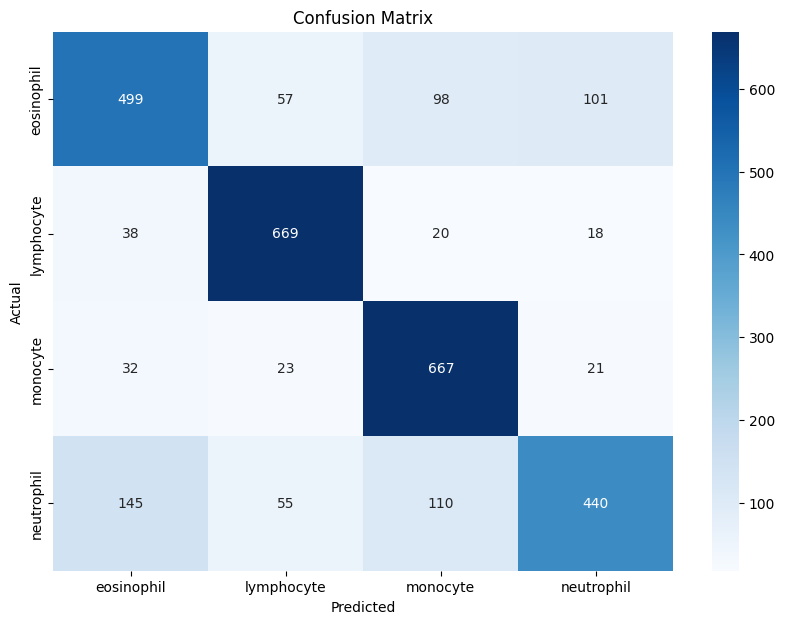

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Predict on the test generator
pred = model.predict(test_gen, verbose=1)

# Get predicted class indices
pred_classes_indices = np.argmax(pred, axis=1)

# Get true class labels from the test generator
true_classes = test_gen.classes
class_indices = test_gen.class_indices
idx_to_class = dict((v, k) for k, v in class_indices.items())
true_class_labels = [idx_to_class[k] for k in true_classes]

# Get predicted class labels
predicted_class_labels = [idx_to_class[k] for k in pred_classes_indices]

# Class labels (must match training folders)
class_labels = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

# Print classification report
print("Classification Report:")
print(classification_report(true_class_labels, predicted_class_labels, target_names=class_labels))

# Calculate and print accuracy score
accuracy = accuracy_score(true_class_labels, predicted_class_labels) * 100
print(f"Accuracy of the Model: {accuracy:.1f}%")

# Plot model accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot model loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Confusion matrix
cm = confusion_matrix(true_class_labels, predicted_class_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [14]:
# Saving the model [cite: 140]
model.save("Blood Cell.h5")